# Results 

This notebook intends to retrieve results that are in the research paper, information is quite straight forward, and only some configuration tools are setup for better analysis. 

- [Space headway](#space_headway)
- [Time headway](#time_headway) 
- [Acceleration](#acceleration)
- [Trajectories](#trajectories)

Check Bokeh for more details into plot configurations 


In [221]:
import os

from sqlalchemy import create_engine, MetaData
from sqlalchemy import Table, Column, String, Integer, Float 
from sqlalchemy import insert, delete, select, case, and_

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

# Bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.sampledata.iris import flowers
from bokeh.io import output_notebook
from bokeh.palettes import Viridis, Spectral8, Reds, Greens, Category20
from bokeh.models import HoverTool, CategoricalColorMapper

output_notebook() 

Loading BokehJS ...

In [2]:
DT = 0.1 # Simulation parameter

KC = 0.16
KH = 0.0896
VF = 25.0
W = 6.25
E  = 25.0*0.3
GCAV = 1/(KC*W)
GHDV = 1/(KH*W)
SCAV = VF/(KC*W)+1/KC
SHDV = VF/(KH*W)+1/KH
dveh_twy = {'CAV': GCAV, 'HDV': GHDV}
dveh_dwy = {'CAV': 1/KC, 'HDV': 1/KH}
U_MAX = 1.5
U_MIN = -1.5

In [3]:
dir_path = os.getcwd()
engine_path = ('..','Output','SymOut.sqlite')
engine_name = os.path.join(os.path.sep,*engine_path)
engine_full_name = os.path.join(dir_path,*engine_path)
engine_call = 'sqlite://'+engine_name
engine = create_engine(engine_call)
metadata = MetaData()

try: 
    ltbstr = 'Loaded table in: '
    connection = engine.connect()    
    traj = Table('traj', metadata, autoload=True, autoload_with=engine)
    closed = Table('closed', metadata, autoload=True, autoload_with=engine)
    headway = Table('headway', metadata, autoload=True, autoload_with=engine)
    control = Table('control', metadata, autoload=True, autoload_with=engine)    
except:
    ltbstr = 'Table could not be loaded: '
finally: 
    print(ltbstr, engine)

Loaded table in:  Engine(sqlite:///../Output/SymOut.sqlite)


In [4]:
stmt = select([closed])
results = connection.execute(stmt).fetchall()
stmt = select([traj])
resultsOL = connection.execute(stmt).fetchall()
column_names = closed.columns.keys()
trajCLDf = pd.DataFrame(results, columns = column_names)
column_names = traj.columns.keys()
trajOLDf = pd.DataFrame(resultsOL, columns = column_names)

In [5]:
trajHDVDf = trajOLDf[trajOLDf['type']=='HDV']

trajCLDf['id'] = trajCLDf['id'].astype('str')
trajHDVDf['id'] = trajHDVDf['id'].astype('str')

sourceCL = ColumnDataSource(trajCLDf)
sourceHDV = ColumnDataSource(trajHDVDf)

CAV_list = trajCLDf.id.unique().tolist()
HDV_list = trajHDVDf.id.unique().tolist()

CAV_colors = [x for i, x in enumerate(Category20[16]) if i % 2 ==0 ]
HDV_colors = [x for i, x in enumerate(Category20[16]) if i % 2 !=0 ]

color_mapper_CAV = CategoricalColorMapper(factors=CAV_list, palette=CAV_colors)
color_mapper_HDV = CategoricalColorMapper(factors=HDV_list, palette=HDV_colors)

colorCAV = dict(field='id', transform=color_mapper_CAV)
colorHDV = dict(field='id', transform=color_mapper_HDV)

hover = HoverTool(tooltips=[('t','@ti'),('x','@abs'),('type','@type'), ('id','@id')])
hoverRef = HoverTool(tooltips=[('t','@ti'), ('id','@id'), ('tau','@tau')])
hoverCtr = HoverTool(tooltips=[('t','@ti'),('u','@ctr'), ('id','@id')])

CAV_colors

/Users/ladino/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f']

<a id='space_headway'></a>
## Space headway

Head space under control 

In [6]:
p = figure(title = "Space headway", 
           width=800, 
           height=800, 
          tools = ['lasso_select', 'wheel_zoom, reset, save'])

p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Spacing [m]'

# Spacing 

p.circle('ti', 'spc', source=sourceCL, color = colorCAV, selection_color = colorCAV, size = 3, nonselection_alpha=0.1)
p.add_tools(hover)
show(p)

#
#trajDf.plot(kind='scatter',x='ti',y ='spc', c = trajDf.tron.map(colormap), figsize = (7.5, 7.5), s = 2, grid = True);

In [7]:
stmt = select([headway])
results = connection.execute(stmt).fetchall()
column_names = headway.columns.keys()
headDf = pd.DataFrame(results, columns = column_names)

<a id='time_headway'></a>
## Time headway 

Time headway under control 

In [8]:
# Control performance 

p = figure(title = "Time Gap", 
           width=800, 
           height=800, 
          tools = ['lasso_select', 'wheel_zoom', 'reset', 'save', 'box_zoom'])

p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Tau [s]'

trajCLDf['tau'] = (trajCLDf['spc']-1/KC).divide(trajCLDf['vit'])
headDf['id'] = headDf['id'].astype('str')
headDf['tau']=headDf['gapt']

REF_list = headDf.id.unique().tolist()

REF_colors = [x for i, x in enumerate(Category20[16]) if i % 2 !=0]

color_mapper_REF = CategoricalColorMapper(factors=REF_list, palette=REF_colors)

sourceTau = ColumnDataSource(trajCLDf)
sourceRef = ColumnDataSource(headDf)

colorREF = dict(field='id', transform=color_mapper_REF)

p.circle('ti', 'tau', source=sourceTau, color = colorCAV, selection_color = colorCAV, size = 3, nonselection_alpha=0.1)
p.circle('ti', 'tau', source=sourceRef, color = colorREF, selection_color = colorREF, size = 3, alpha = 0.2, nonselection_alpha=0.1)
p.add_tools(hoverRef)
show(p)



<a id='acceleration'></a>
## Acceleration signal 

Contorl input for CAVs

In [9]:
stmt = select([control])
results = connection.execute(stmt).fetchall()
column_names = control.columns.keys()
controlDf = pd.DataFrame(results, columns = column_names)

In [10]:
p = figure(title = "Control signal", 
           width=800, 
           height=800, 
          tools = ['lasso_select', 'wheel_zoom, reset, save'])

p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'Acceleration [ms-2]'

controlDf['id'] = controlDf['id'].astype('str')

sourceCTRL = ColumnDataSource(controlDf)

p.circle('ti', 'ctr', source=sourceCTRL, color = colorCAV, selection_color = colorCAV, size = 3, nonselection_alpha=0.1)
p.add_tools(hoverCtr)
show(p)

<a id='trajectories'></a>
## Trajectories 

Space time after control 

In [238]:
p = figure(title = "Trajectories", 
           width=800, 
           height=800, 
          tools = ['lasso_select', 'wheel_zoom', 'reset', 'save','box_zoom'])

p.xaxis.axis_label = 'Time [s]'
p.yaxis.axis_label = 'X [m]'



p.circle('ti', 'abs', source=sourceHDV, color = colorHDV, selection_color = colorHDV, size = 1, nonselection_alpha=0.1)
p.circle('ti', 'abs', source=sourceCL, color = colorCAV, selection_color = colorCAV, size = 1, nonselection_alpha=0.1)
# p.circle('ti', 'abs', source=sourceHDV, color = 'salmon', size = 3)
# p.circle('ti', 'abs', source=sourceCL, color = 'deepskyblue', size = 3)
p.add_tools(hover)

show(p)


#### Export plots 

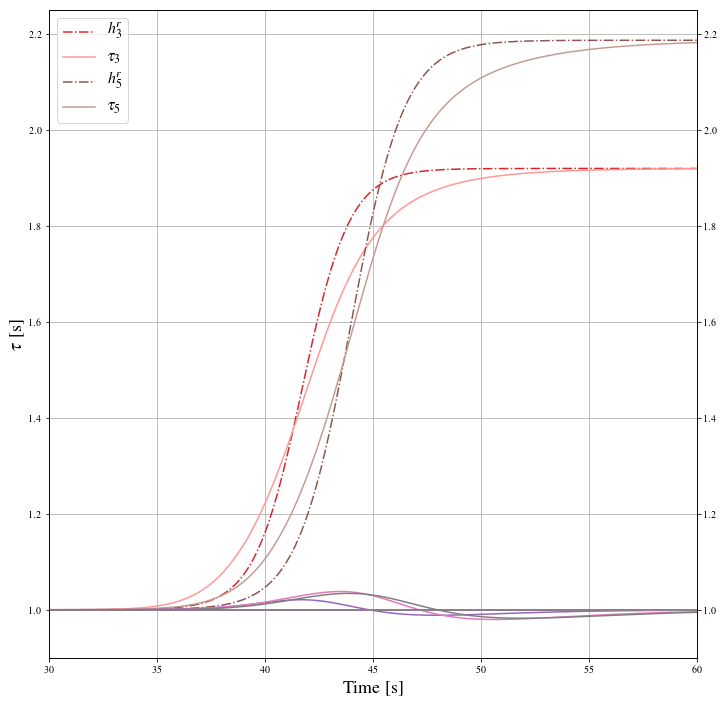

In [137]:
#plt.style.use('default')
cmap = plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N) if i%2 ==0 ]
cmaplist2 = [cmap(i) for i in range(cmap.N) if i%2 !=0 ]


f = plt.figure(figsize = (3,3))
ax1 = plt.axes([0.050, 0.05, 3, 3])
plt.rc('font', **{'family':'serif','sans-serif':['Times']})
plt.rc('text', usetex=True)

ax1.grid(True)
plt.xlabel(r'Time [s]', fontsize=18)
plt.ylabel(r'$\tau$ [s]', fontsize=18)
#plt.title('Time Shift Performance', fontsize=18)
plt.xlim([30, 60])
ax2 = ax1.twinx()
j = 0

for i in headDf.id.unique():
    sub = headDf[headDf['id']==i]
    sub2 = trajCLDf[trajCLDf['id']==i]
    mycolor = cmaplist[j]
    mycolorref = cmaplist2[j]    
    if i == '5' or i == '3':
        mylabelref = r'$h^r_{}$'.format(i)
        mylabelans = r'$\tau_{}$'.format(i)
        ax1.plot(sub['ti'],sub['tau'], '-.',color=mycolor, label=mylabelref)
        ax1.plot(sub2['ti'],sub2['tau'],'-', color=mycolorref, label=mylabelans)
        ax1.set_ylim([0.9,2.25])
    else:
        ax2.plot(sub['ti'],sub['tau'], color=mycolor)
        ax2.plot(sub2['ti'],sub2['tau'], color=mycolor)  
        ax2.set_ylim([0.9,2.25])
    j+= 1
    
ax1.legend(loc = 'best', fontsize = 16)    
sub = headDf[headDf['id']=='3']    

plt.savefig('../Output/5_reference_low_level.png', dpi = 300, bbox_inches='tight')


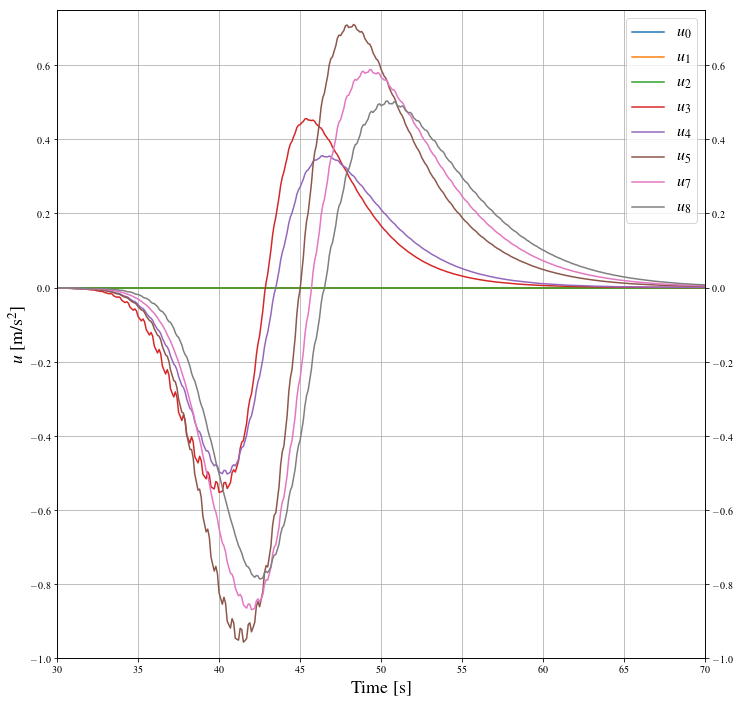

In [138]:
#plt.style.use('default')
cmap = plt.cm.tab20
cmaplist = [cmap(i) for i in range(cmap.N) if i%2 ==0 ]
cmaplist2 = [cmap(i) for i in range(cmap.N) if i%2 !=0 ]


f = plt.figure(figsize = (3,3))
ax1 = plt.axes([0.050, 0.05, 3, 3])
plt.rc('font', **{'family':'serif','sans-serif':['Times']})
plt.rc('text', usetex=True)

ax1.grid(True)
plt.xlabel(r'Time [s]', fontsize=18)
plt.ylabel(r'$u$ [m/s$^2$]', fontsize=18)
#plt.title('Control input', fontsize=18)
plt.xlim([30, 70])
ax2 = ax1.twinx()
j = 0

for i in headDf.id.unique():
    sub = controlDf[controlDf['id']==i]
    mycolor = cmaplist[j]
    mycolorref = cmaplist2[j]    
    mylabelref = r'$u_{}$'.format(i)
    ax1.plot(sub['ti'],sub['ctr'],'-',color=mycolor, label=mylabelref)
    ax1.set_ylim([-1,0.75])
    ax2.set_ylim([-1,0.75])
    j+= 1
    
ax1.legend(loc = 'best', fontsize = 16)    
sub = headDf[headDf['id']=='3']    

plt.savefig('../Output/5_accelerations_vehicles.png', dpi = 300, bbox_inches='tight')

/Users/ladino/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


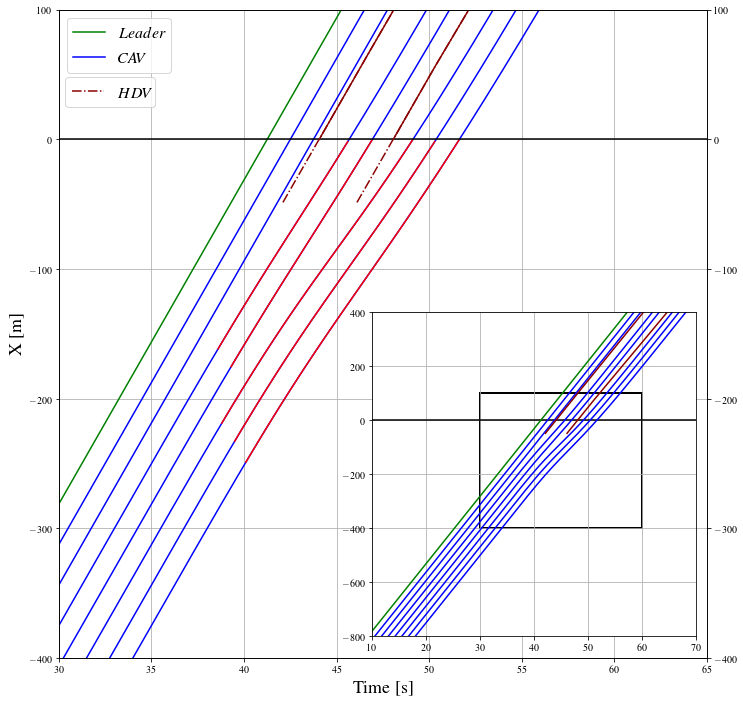

In [247]:


# variable to parametrize color 
colorparams = trajCLDf['vit']

# Choose a colormap
cmap = plt.cm.viridis
cmap2 = plt.cm.viridis

cmaplist = [cmap(i) for i in range(cmap.N) if i%2 ==0 ]
cmaplist2 = [cmap2(i) for i in range(cmap.N) if i%2 !=0 ]

                      
f = plt.figure(figsize = (3,3))
ax1 = plt.axes([0.050, 0.05, 3, 3])
plt.rc('font', **{'family':'serif','sans-serif':['Times']})
plt.rc('text', usetex=True)

ax1.grid(True)
plt.xlabel(r'Time [s]', fontsize=18)
plt.ylabel(r'X [m]', fontsize=18)
#plt.title('Control input', fontsize=18)
plt.xlim([30, 65])

ax2 = ax1.twinx()
ax1.set_ylim([-400,100])
ax2.set_ylim([-400,100])

for i in headDf.id.unique():
    sub = trajCLDf[trajCLDf['id']==i]
    sub2 = sub[(sub['vit']<24.0) & (sub['abs']<0)]
    mycolor = 'blue' if i!='0' else 'green'
    mycolor2 = 'red'
    mylabelref = r'$CAV$' if i=='0' else None
    ax1.plot(sub['ti'],sub['abs'],'-',color=mycolor)
    if i!='0':
        ax1.plot(sub2['ti'],sub2['abs'],'-',color=mycolor2)

ax1.axhline(y=0, color = 'k')
    
ax1.legend([r'$Leader$', r'$CAV$'],loc = 'upper left', fontsize = 16) 



    
for k in trajHDVDf.id.unique():
    sub2 = trajHDVDf[(trajHDVDf['id']==k) & (trajHDVDf['abs']>=-50.0)]    
    sub3 = sub2[sub2['abs']>=0]    
    mycolor = 'darkred'
    ax2.plot(sub2['ti'],sub2['abs'],'-.',color=mycolor)
    ax2.plot(sub3['ti'],sub3['abs'],'-',color=mycolor)    

ax2.legend([r'$HDV$'], loc = (0.01, 0.85), fontsize = 16)   

sub = headDf[headDf['id']=='3']    

ax3 = plt.axes([1.5, 0.15, 1.5, 1.5])
ax4 = plt.axes([1.5, 0.15, 1.5, 1.5])
ax3.grid(True)
ax3.set_ylim([-800,400])
ax3.set_xlim([10,70])
ax3.axhline(y=0, color = 'k')
j = 0

for i in headDf.id.unique():
    sub = trajCLDf[trajCLDf['id']==i]
    mycolor = 'blue' if i!='0' else 'green'
    mylabelref = r'$CAV$' if i=='0' else None
    ax3.plot(sub['ti'],sub['abs'],'-',color=mycolor)

for k in trajHDVDf.id.unique():
    sub2 = trajHDVDf[(trajHDVDf['id']==k) & (trajHDVDf['abs']>=-50.0)]      
    mycolor = 'darkred'
    ax4.plot(sub2['ti'],sub2['abs'],'-',color=mycolor)
    
someX, someY = 30, -400
ax3.add_patch(Rectangle((someX, someY), 30, 500, fc='white',ec ='k', alpha=0.3, lw= 2))   
ax3.add_patch(Rectangle((someX, someY), 30, 500, fill= None , alpha=1, lw= 2))   
plt.savefig('../Output/5_trajectories_vehicles.png', dpi = 300, bbox_inches='tight')